In [17]:
import pandas as pd
from collections import defaultdict
import string
import numpy as np
from gensim.models import KeyedVectors
import torch

In [18]:
# knock80をまとめたもの
class make_and_translate_ID():
    def __init__(self, data):
        self.train_dict = defaultdict(int)
        self.id_list = []
        self.id_dict = dict()
        self.make_id(data)

    def make_id(self, data):
        for line in data:
            words = line.translate(table).split()
            for word in words:
                self.train_dict[word] += 1
        calc_dict = dict(self.train_dict)
        sort_list = sorted(calc_dict.items(), key=lambda x: x[1], reverse=True)
        for i, (trg_word, freq) in enumerate(sort_list):
            if freq >= 2:
                self.id_list.append((trg_word, i+1))
            else:
                self.id_list.append((trg_word, 0))
        self.id_dict = dict(self.id_list)

    def return_id(self, line):
        one_hot_vec = []
        words = line.strip().split(" ")
        for word in words:
            if word in self.id_dict.keys():
                one_hot_vec.append(self.id_dict[word])
            else:
                one_hot_vec.append(0)
        return one_hot_vec

In [19]:
#全ての句読点文字をスペースに置き換える翻訳テーブル
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
header_name = ['TITLE', 'CATEGORY']

train_data = pd.read_csv("../chapter06/train.txt", header=None,sep='\t', names=header_name)

w2id = make_and_translate_ID(train_data["TITLE"])
test_vec = w2id.return_id(train_data["TITLE"][10])
print(train_data["TITLE"][10])
print(test_vec)

UPDATE 3-Big US banks' funding advantage reduced, could rise in crisis-official
[4, 0, 7, 0, 3046, 5175, 0, 175, 123, 3, 0]


In [20]:
model = KeyedVectors.load_word2vec_format('../chapter07/GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(w2id.id_dict.keys())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))#lenがVOCAB_SIZEの，EMB_SIZE個ずつ0が入っている配列
words_in_pretrained = 0

# 与えられた単語に対し，学習済モデルから単語埋め込み(=ベクトル)を取得する
for i, word in enumerate(w2id.id_dict.keys()):
    #i:単語ID，　word:単語
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:#キーがなければランダムなベクトルを生成
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))

weights = torch.from_numpy(weights.astype((np.float32)))#torch.from_numpy: ndarrayからtensorを作る
print(f'学習済単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済単語数: 16412 / 17157
torch.Size([17157, 300])


In [21]:
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn import functional as F

In [22]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        """
        vocab_size: 語彙サイズ
        emb_size: 埋め込み層サイズ
        padding_idx: ↑でパディングに使うインデックス
        output_size: 出力サイズ
        out_channels: 畳み込みの出力チャンネル数
        kernel_heights: 畳み込みカーネルの高さ
        stride: 畳み込みのストライド
        padding: 畳み込みのパディング
        emb_weights: 事前学習済みの埋め込み重なり
        """
        super().__init__()
        if emb_weights != None:  #埋め込み層の定義
          self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
          self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))#畳み込み層の定義
        self.drop = nn.Dropout(0.3)#過学習を防ぐためにランダムに1部分のニューロンを無効
        self.fc = nn.Linear(out_channels, output_size)#全結合層の定義

    def forward(self,x):
        emb = self.emb(x).unsqueeze(1)#畳み込み層の適用
        conv = self.conv(emb)#畳み込み層の適用
        act = F.relu(conv.squeeze(3))#活性化関数の適用
        max_pool = F.max_pool1d(act, act.size()[2])#最大プーリング層の適用
        out = self.fc(self.drop(max_pool.squeeze(2)))#全結合層とドロップアウトの適用
        return out

In [23]:
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[idx], dtype=torch.int64)
        }

In [24]:
train = pd.read_csv("../chapter06/train.txt", sep='\t')
valid = pd.read_csv("../chapter06/valid.txt", sep='\t')
test = pd.read_csv("../chapter06/test.txt", sep='\t')

category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)

In [25]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import time
from torch import optim
import numpy as np
from matplotlib import pyplot as plt

In [26]:
# knock82より
# 損失の正解率の計算
def calc_loss_and_acc(model, dataset, device=None, criterion=None):
    # model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(dataset), correct / total

In [27]:
# knock82より
# 学習する
def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None, collate_fn=None):
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_and_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_and_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'./k87_saves/checkpoint{epoch + 1}.pt')

        print(f"epoch: {epoch+1},"
        f"loss_train: {loss_train:.4f},"
        f"accuracy_train: {acc_train:.4f},"
        f"loss_valid: {loss_valid:.4f},"
        f"accuracy_valid: {acc_valid:.4f},"
        f"train_time: {(end_time - start_time):.4f}sec")
    return {
        "train": log_train,
        "valid": log_valid
    }

In [28]:
# knock83より
#　損失，正解率の可視化
def make_graph_by_logs(log, savename):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig(savename)

In [29]:
# ミニバッチ化，GPU上で計算
#バッチデータを統一すること
class Padseq():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(
            batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(
            sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

In [30]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

device = torch.device("mps")

/var/folders/1p/m23jt2g15kz8d77xv0qpzbt40000gn/T/ipykernel_77394/3360178210.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1,loss_train: 1.1479,accuracy_train: 0.4701,loss_valid: 1.1571,accuracy_valid: 0.4648,train_time: 3.3434sec
epoch: 2,loss_train: 1.1283,accuracy_train: 0.4903,loss_valid: 1.1502,accuracy_valid: 0.4715,train_time: 3.2176sec
epoch: 3,loss_train: 1.0729,accuracy_train: 0.5841,loss_valid: 1.1019,accuracy_valid: 0.5547,train_time: 3.2305sec
epoch: 4,loss_train: 0.9974,accuracy_train: 0.6257,loss_valid: 1.0354,accuracy_valid: 0.5990,train_time: 3.2169sec
epoch: 5,loss_train: 1.0303,accuracy_train: 0.5678,loss_valid: 1.0922,accuracy_valid: 0.5435,train_time: 3.2186sec
epoch: 6,loss_train: 0.8743,accuracy_train: 0.6948,loss_valid: 0.9354,accuracy_valid: 0.6657,train_time: 3.2123sec
epoch: 7,loss_train: 0.8189,accuracy_train: 0.7120,loss_valid: 0.8956,accuracy_valid: 0.6852,train_time: 3.2151sec
epoch: 8,loss_train: 0.7944,accuracy_train: 0.7070,loss_valid: 0.8835,accuracy_valid: 0.6754,train_time: 3.1909sec
epoch: 9,loss_train: 0.7472,accuracy_train: 0.7290,loss_valid: 0.8488,accuracy_v

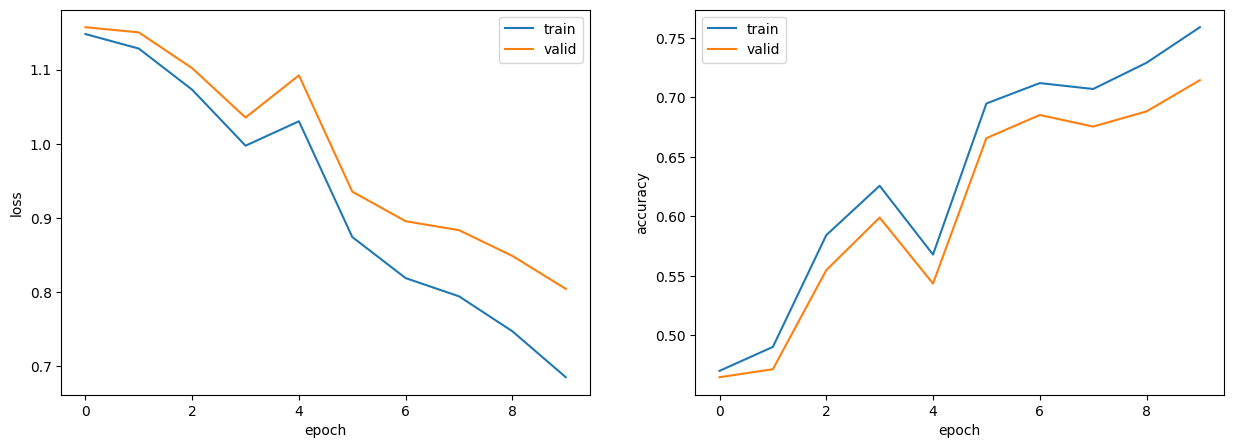

In [31]:
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

make_graph_by_logs(log, "./graphs/knock87.png")
_, acc_train = calc_loss_and_acc(model, dataset_train,device)
_, acc_test = calc_loss_and_acc(model, dataset_test,device)
print(f'Train Accuracy: {acc_train:.3f}')
print(f'Test Accuracy: {acc_test:.3f}')